# SanityChecker 2 – Patch-Clamp Ephys Sanity Checks  

A slim, self-contained notebook for quickly validating voltage- and current-clamp data **without** relying on the heavy helper functions in `PatchAnalyzer/utils/passives.py` or `…/spike_params.py`.

* 1️⃣ Passive properties from VC (optional) & CC sweeps  
* 2️⃣ Spike detection → F–I curve & per-spike metrics  
* 3️⃣ One-click plot toggles for debugging  
* Copy-paste-ready cells; all user inputs live in the next “Config” cell


In [ ]:
# ---------------------------------------------------------------------
# 🛠️  USER CONFIG  – fill / tweak these and rerun the rest of the nb
# ---------------------------------------------------------------------
from pathlib import Path
import sys, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ▶ 1. Re-point to your experiment folders (same as GUI Welcome Page)
EXP_DIRS = [
    # Example:
    # Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58"),
    Path(r"C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_07_02-13_09"),   # uncomment to add more
]

# ▶ 2. Pick ONE experiment and ONE recorder cell-ID from that experiment
EXP_DIR  = EXP_DIRS[0] if EXP_DIRS else None     # Path or None
CELL_ID  = 3                                    # int

# ▶ 3. Global plot toggles  (set False to skip)
SHOW_RAW_PLOTS      = True    # all raw cmd/rsp traces
SHOW_PASSIVE_PLOTS  = True    # exp fit overlays
SHOW_FI_PLOTS       = True    # F–I curve
SHOW_SPIKE_PLOTS    = True    # per-spike overlays

# ---------------------------------------------------------------------
# Repo root → sys.path  (two levels up from PatchAnalyzer/AnalysisTesting)
# ---------------------------------------------------------------------
if EXP_DIR is None:
    raise RuntimeError("⚠ Please populate EXP_DIRS before running further cells.")

repo_root = EXP_DIR.parents[2]        # …/ProjectRoot/
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

plt.rcParams["figure.dpi"] = 110


In [2]:
# ---------------------------------------------------------------------
# 📚  LIGHTWEIGHT HELPERS
# ---------------------------------------------------------------------
import numpy as np
from scipy import signal, optimize

# 2.1  Test-pulse finder
def find_test_pulse(cmd, edge_frac=0.05, min_pts=5):
    cmd = np.asarray(cmd)
    n_bl = max(1, int(0.05 * cmd.size))
    baseline = np.median(cmd[:n_bl])
    mad = np.median(np.abs(cmd[:n_bl] - baseline))
    sigma = 1.4826 * mad if mad else np.std(cmd[:n_bl])
    thr = max(1e-3, sigma * (edge_frac * 100))
    mask = np.abs(cmd - baseline) > thr
    runs = np.split(np.where(mask)[0],
                    np.where(np.diff(np.where(mask)[0]) > 1)[0] + 1)
    runs = [r for r in runs if len(r) >= min_pts]
    return (int(runs[0][0]), int(runs[0][-1])) if runs else (None, None)

# 2.2  Experimental-pulse finder  (needs *after_idx* = test-pulse end)
def find_experimental_pulse(cmd, after_idx, min_pts=10):
    """
    Find first region after `after_idx` where |cmd - baseline| > dynamic thr.
    Baseline = median of the 2 % of samples *immediately* after `after_idx`.
    """
    if after_idx is None or after_idx >= cmd.size-1:
        return None, None

    post = cmd[after_idx : after_idx + max(1, int(0.02*cmd.size))]
    baseline = np.median(post)
    # threshold = max(2 pA, 5 % of full range)
    thr = max(2.0, 0.05 * np.ptp(cmd))

    mask = np.abs(cmd - baseline) > thr
    idxs = np.where(mask & (np.arange(cmd.size) > after_idx))[0]
    if idxs.size == 0:
        return None, None

    runs = np.split(idxs, np.where(np.diff(idxs) > 1)[0] + 1)
    runs = [r for r in runs if len(r) >= min_pts]
    if not runs:
        return None, None

    s, e = int(runs[0][0]), int(runs[0][-1])
    return s, e


# 2.3  Spike & width helpers (unchanged)
def detect_spikes(trace_mV, sr_Hz, prom_mV=12, smooth_pts=50):
    sm = signal.convolve(trace_mV,
                         np.ones(smooth_pts)/smooth_pts,
                         mode="same")
    peaks, _ = signal.find_peaks(
        sm,
        prominence=prom_mV,
        height=trace_mV.min() + 0.05*np.ptp(trace_mV)
    )
    return peaks

def half_width(trace_mV, peak_idx, sr_Hz, prom_mV, window_ms=3.0):
    dt = 1/sr_Hz
    win = int(window_ms/1000 / dt)
    half_val = trace_mV[peak_idx] - 0.5*prom_mV
    local = trace_mV[peak_idx-win : peak_idx+win]
    xloc = np.where(local > half_val)[0]
    return (xloc[-1]-xloc[0])*dt*1e3 if xloc.size >= 2 else None



In [3]:
# ---------------------------------------------------------------------
# 🔄  LOAD METADATA + ALL TRACES for the chosen experiment
# ---------------------------------------------------------------------
from PatchAnalyzer.models.data_loader import load_metadata
from PatchAnalyzer.models.ephys_loader import (
    load_voltage_traces_for_indices,
    load_current_traces,
)

meta_df = load_metadata([EXP_DIR])
idx_col = "indices" if "indices" in meta_df.columns else "index"
if idx_col not in meta_df.columns:
    raise RuntimeError("Metadata missing Index column")

# Build nested dict  {(x,y,z): {'vc': [...], 'cc': {cell: {I:trace}}}}
cells = {}
for coord, sub in meta_df.groupby(["stage_x","stage_y","stage_z"]):
    sweep_idxs = sub[idx_col].tolist()
    vc = list(load_voltage_traces_for_indices(EXP_DIR, sweep_idxs).values())
    cc = load_current_traces(EXP_DIR, sweep_idxs)
    cells[coord] = dict(vc=vc, cc=cc)

print(f"Loaded {len(cells)} physical cell-locations")


2025-07-15 19:02:52,753 [INFO] Logging to C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\PatchAnalyzer\logs\run-20250715-190252.log
2025-07-15 19:02:52,757 [INFO] Loaded 6 rows from C:\Users\sa-forest\Documents\GitHub\PatchAnalyzer\Data\Test\2025_06_25-15_58\CellMetadata\cell_metadata.csv
Loaded 2 physical cell-locations


Cell 2: 5 VC traces, 23 CC sweeps


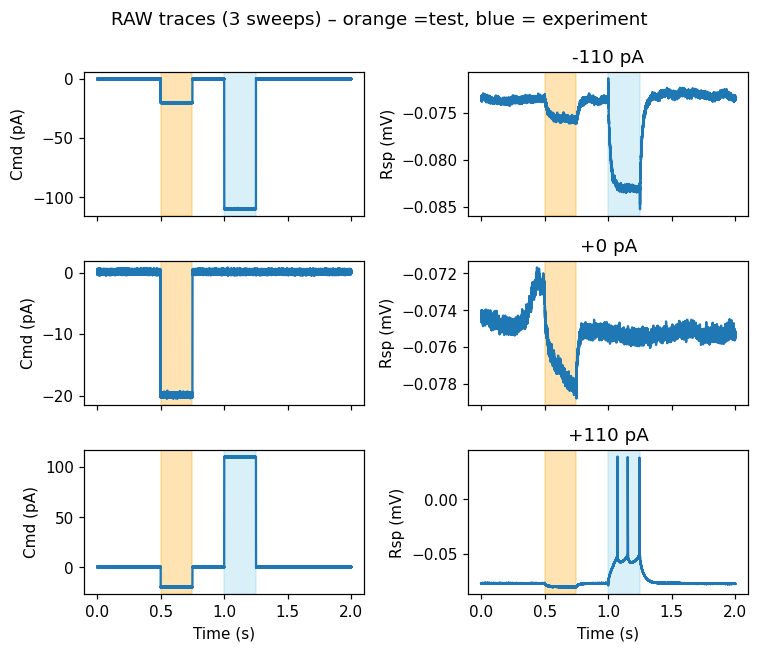

In [4]:
# ---------------------------------------------------------------------
# 🎯  FOCUS ON ONE RECORDER CELL
# ---------------------------------------------------------------------
coord_key = None
for coord, d in cells.items():
    if CELL_ID in d["cc"]:
        coord_key = coord
        break
if coord_key is None:
    raise RuntimeError(f"Cell {CELL_ID} not found in {EXP_DIR}")

vc_traces = cells[coord_key]["vc"]
cc_dict   = cells[coord_key]["cc"][CELL_ID]

print(f"Cell {CELL_ID}: {len(vc_traces)} VC traces, "
      f"{len(cc_dict)} CC sweeps")

# pick 3 representative currents
I_sorted = sorted(cc_dict.keys())
sel_currents = (I_sorted if len(I_sorted) < 3 else
                [I_sorted[0],
                 min(I_sorted, key=lambda x: abs(x)),
                 I_sorted[-1]])

# --- diagnostic plot -------------------------------------------------
if SHOW_RAW_PLOTS:
    fig, axs = plt.subplots(len(sel_currents), 2,
                            figsize=(7, 2*len(sel_currents)),
                            sharex='col')
    for I, ax in zip(sel_currents, axs):
        t, cmd, rsp = cc_dict[I]
        ts, te = find_test_pulse(cmd)
        es, ee = find_experimental_pulse(cmd, te) if te else (None, None)

        ax[0].plot(t, cmd); ax[0].set_ylabel("Cmd (pA)")
        ax[1].plot(t, rsp); ax[1].set_ylabel("Rsp (mV)")
        if ts is not None:
            for a in ax: a.axvspan(t[ts], t[te], color='orange', alpha=.3)
        if es is not None:
            for a in ax: a.axvspan(t[es], t[ee], color='skyblue', alpha=.3)
        ax[1].set_title(f"{I:+.0f} pA")
    axs[-1][0].set_xlabel("Time (s)")
    axs[-1][1].set_xlabel("Time (s)")
    plt.suptitle("RAW traces (3 sweeps) – orange =test, blue = experiment")
    plt.tight_layout(); plt.show()




VC fit: Ra 37.6 MΩ   Rm 47.4 MΩ   Cm 112.8 pF
VC fit: Ra 77.3 MΩ   Rm 47.4 MΩ   Cm 127.1 pF
VC fit: Ra 22.6 MΩ   Rm 52.2 MΩ   Cm 125.5 pF
VC fit: Ra 22.8 MΩ   Rm 46.4 MΩ   Cm 153.2 pF
VC fit: Ra 21.2 MΩ   Rm 47.0 MΩ   Cm 177.8 pF
VC mean of 5 fits → Ra 36.3 MΩ   Rm 48.1 MΩ   Cm 139.3 pF


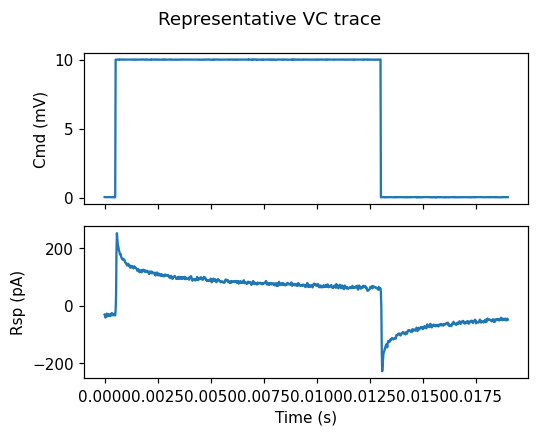

In [5]:
# ---------------------------------------------------------------------
# ⚙️  PASSIVE PROPERTIES from Voltage-Clamp (uses library function)
# ---------------------------------------------------------------------
from PatchAnalyzer.utils.passives import compute_passive_params

vc_results = []
for t, cmd_V, rsp_A in vc_traces:
    Ra, Rm, Cm = compute_passive_params(t, cmd_V, rsp_A)
    if all(v is not None for v in (Ra, Rm, Cm)):
        vc_results.append((Ra, Rm, Cm))
    print(f"VC fit: Ra {Ra:.1f} MΩ   Rm {Rm:.1f} MΩ   Cm {Cm:.1f} pF")

if vc_results:
    Ra_mohm, Rm_mohm, Cm_pf = map(np.mean, zip(*vc_results))
    print(f"VC mean of {len(vc_results)} fits → "
          f"Ra {Ra_mohm:.1f} MΩ   Rm {Rm_mohm:.1f} MΩ   Cm {Cm_pf:.1f} pF")
else:
    Ra_mohm = Rm_mohm = Cm_pf = np.nan
    print("⚠ No successful VC fits")

# representative overlay – show BOTH command (mV) and response (pA)
if SHOW_PASSIVE_PLOTS and vc_traces:
    t, cmd_V, rsp_A = vc_traces[0]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,4), sharex=True)
    ax1.plot(t, cmd_V*1e3); ax1.set_ylabel("Cmd (mV)")
    ax2.plot(t, rsp_A*1e12); ax2.set_ylabel("Rsp (pA)")
    ax2.set_xlabel("Time (s)")
    plt.suptitle("Representative VC trace"); plt.tight_layout(); plt.show()


C:\Users\sa-forest\AppData\Local\Temp\ipykernel_21784\1434676147.py:38: RuntimeWarning: overflow encountered in exp
  lambda x, m, k, b: m*np.exp(-k*x)+b,
C:\Users\sa-forest\AppData\Local\Temp\ipykernel_21784\1434676147.py:38: RuntimeWarning: overflow encountered in multiply
  lambda x, m, k, b: m*np.exp(-k*x)+b,


,current_pA,Holding_pA,Rest_mV,Rin_MOhm,tau_ms,Cm_pF
0,-110.0,0.078520,-73.547959,111.298945,27.719901,249.058073
1,-100.0,0.085130,-73.261632,90.038009,70.043820,777.936126
2,-90.0,0.102752,-71.434440,138.236132,21.213543,153.458745
3,-80.0,0.075697,-71.454714,147.302335,21.963971,149.108098
4,-70.0,0.113610,-69.816426,173.937607,29.303232,168.469788
5,-60.0,0.131290,-70.237129,165.069148,25.709777,155.751560
6,-50.0,0.137254,-69.570455,192.835241,60.837616,315.490135
7,-40.0,0.169779,-72.215345,140.478397,16.459255,117.165738
8,-30.0,0.158698,-72.337244,121.737738,40.246601,330.600859
9,-20.0,0.171454,-72.462578,203.765700,27.965622,137.244009


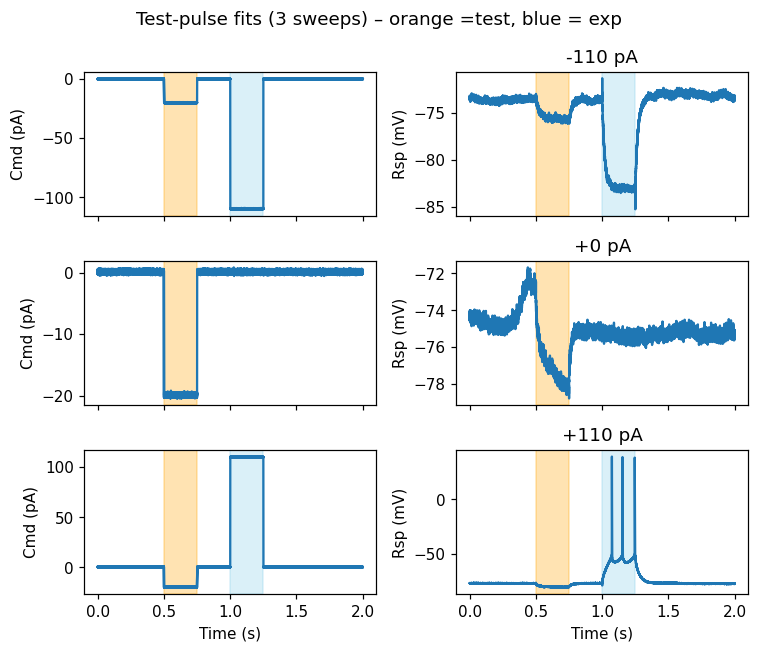

In [6]:
# ---------------------------------------------------------------------
# 🔍  CURRENT-CLAMP passive parameters – per sweep  (loader already pA)
# ---------------------------------------------------------------------
BASELINE_MS = 20
FIT_MS      = 80
MIN_DI_PA   = 5       # skip sweeps with <5 pA test pulse

cc_rows = []
for I, (t, cmd, rsp) in cc_dict.items():
    ts, te = find_test_pulse(cmd)
    if ts is None:
        continue

    dt = t[1] - t[0]

    # ── baseline & steady-state voltages ───────────────────────────────
    pre_win  = slice(max(0, ts-int(BASELINE_MS/1000/dt)), ts)
    ss_win   = slice(te-int(BASELINE_MS/1000/dt), te)

    V_pre   = np.mean(rsp[pre_win])          # V
    V_ss    = np.mean(rsp[ss_win])           # V
    dV_mV   = (V_ss - V_pre) * 1e3           # mV

    I_hold  = np.mean(cmd[:ts-10])           # pA
    I_step  = np.mean(cmd[ts:te]) - I_hold   # pA
    if abs(I_step) < MIN_DI_PA:
        continue

    # ── Corrected unit scaling  (mV/pA → MΩ) ──────────────────────────
    Rin_MΩ = abs(dV_mV / I_step) * 1000      # ★ multiply by 1000

    # ── τ fit (first 80 ms) ────────────────────────────────────────────
    fit_pts = int(FIT_MS/1000 / dt)
    Xfit_ms = (t[ts:ts+fit_pts] - t[ts]) * 1e3
    Yfit_mV = rsp[ts:ts+fit_pts]*1e3 - V_ss*1e3
    try:
        popt, _ = optimize.curve_fit(
            lambda x, m, k, b: m*np.exp(-k*x)+b,
            Xfit_ms, Yfit_mV, p0=(Yfit_mV[0], 10, 0), maxfev=20000)
        tau_ms = 1 / popt[1]
    except Exception:
        tau_ms = np.nan

    # ── Capacitance with consistent units ─────────────────────────────
    Cm_pF = tau_ms * 1000 / Rin_MΩ           # ★ tau(ms)*1e3 / Rin(MΩ)

    Rest_mV = V_pre*1e3                      # baseline Vm

    cc_rows.append(dict(current_pA       = I,
                        Holding_pA       = I_hold,
                        Rest_mV          = Rest_mV,
                        Rin_MOhm         = Rin_MΩ,
                        tau_ms           = tau_ms,
                        Cm_pF            = Cm_pF))
    


# Build DataFrame from your rows and sort it by "current_pA", then reset the index
cc_df = (pd.DataFrame(cc_rows)
           .sort_values("current_pA")
           .reset_index(drop=True))

# Calculate mean and standard deviation for the "current_pA" column
mean_val = cc_df["tau_ms"].mean()
std_val = cc_df["tau_ms"].std()

# Remove outliers: keep rows where the value is within 3 standard deviations from the mean
cc_df_filtered = cc_df[abs(cc_df["tau_ms"] - mean_val) <= 3 * std_val]



# Create a DataFrame for the Mean row
mean_row = pd.DataFrame([{
    "current_pA": "Mean",
    "Holding_pA": cc_df_filtered["Holding_pA"].mean(),
    "Rest_mV": cc_df_filtered["Rest_mV"].mean(),
    "Rin_MOhm": cc_df_filtered["Rin_MOhm"].mean(),
    "tau_ms": cc_df_filtered["tau_ms"].mean(),
    "Cm_pF": cc_df_filtered["Cm_pF"].mean()
}])

# Create a DataFrame for the Std row
std_row = pd.DataFrame([{
    "current_pA": "Std",
    "Holding_pA": cc_df_filtered["Holding_pA"].std(),
    "Rest_mV": cc_df_filtered["Rest_mV"].std(),
    "Rin_MOhm": cc_df_filtered["Rin_MOhm"].std(),
    "tau_ms": cc_df_filtered["tau_ms"].std(),
    "Cm_pF": cc_df_filtered["Cm_pF"].std()
}])

# Concatenate the new rows to the existing DataFrame
cc_df_filtered = pd.concat([cc_df_filtered, mean_row, std_row], ignore_index=True)

# Display the filtered DataFrame
display(cc_df_filtered)



# ------- condensed diagnostic plots (3 currents) – separate axes -------
if SHOW_PASSIVE_PLOTS and len(sel_currents):
    fig, axs = plt.subplots(len(sel_currents), 2,
                            figsize=(7, 2*len(sel_currents)),
                            sharex='col')
    for (I, (t, cmd, rsp)), (ax_cmd, ax_rsp) in zip(
            ((I, cc_dict[I]) for I in sel_currents), axs):

        ts, te = find_test_pulse(cmd)
        es, ee = find_experimental_pulse(cmd, te) if te else (None, None)

        # Command (pA)
        ax_cmd.plot(t, cmd);  ax_cmd.set_ylabel("Cmd (pA)")
        if ts is not None:
            ax_cmd.axvspan(t[ts], t[te], color='orange', alpha=.3)
        if es is not None:
            ax_cmd.axvspan(t[es], t[ee], color='skyblue', alpha=.3)

        # Response (mV)
        ax_rsp.plot(t, rsp*1e3); ax_rsp.set_ylabel("Rsp (mV)")
        if ts is not None:
            ax_rsp.axvspan(t[ts], t[te], color='orange', alpha=.3)
        if es is not None:
            ax_rsp.axvspan(t[es], t[ee], color='skyblue', alpha=.3)

        ax_rsp.set_title(f"{I:+.0f} pA")

    axs[-1][0].set_xlabel("Time (s)")
    axs[-1][1].set_xlabel("Time (s)")
    plt.suptitle("Test-pulse fits (3 sweeps) – orange =test, blue = exp")
    plt.tight_layout(); plt.show()


Normalising injected current by Cm = 192.75 pF


,current_pApF,current_pA,mean_firing_frequency_Hz
0,-0.569041,-109.682303,0.00000
1,-0.517876,-99.820296,0.00000
2,-0.465465,-89.718089,0.00000
3,-0.413704,-79.741229,0.00000
4,-0.362006,-69.776550,0.00000
5,-0.310692,-59.885743,0.00000
6,-0.258437,-49.813640,0.00000
7,-0.207360,-39.968457,0.00000
8,-0.155276,-29.929399,0.00000
9,-0.103667,-19.981723,0.00000


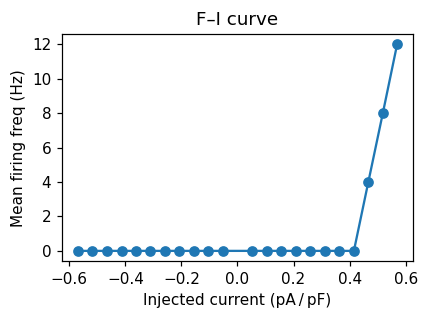

In [7]:
# ---------------------------------------------------------------------
# ⚡  SPIKE DETECTION  &  F–I CURVE  (normalised by cc_df_filtered)
# ---------------------------------------------------------------------
from PatchAnalyzer.utils.spike_params import Sweep

C_CLAMP_AMP_PER_VOLT = 400          # pA / V
THRESH_DVDT          = 50           # mV/ms (used later)

# ── helper ------------------------------------------------------------
def step_current_pA(cmd, start, end):
    """Return baseline‑subtracted step amplitude in pA."""
    if np.ptp(cmd) < 5:                 # volts → convert
        cmd = cmd * C_CLAMP_AMP_PER_VOLT
    I_hold = np.median(cmd[:start-10])
    return float(np.mean(cmd[start:end]) - I_hold)

# ── build Sweep containers -------------------------------------------
sweeps = []
for _, (t, cmd, rsp) in cc_dict.items():
    sr = 1/(t[1]-t[0])
    sweeps.append(Sweep(time=t,
                        response_mV=rsp*1e3,
                        command_pA=cmd,
                        sample_rate=sr))

# ── mean Cm [pF] strictly from cc_df_filtered -------------------------
if 'cc_df_filtered' not in globals() or cc_df_filtered.empty:
    raise RuntimeError("cc_df_filtered is missing or empty – can't normalise.")

if "Cm_pF" not in cc_df_filtered.columns or cc_df_filtered["Cm_pF"].isna().all():
    raise RuntimeError("cc_df_filtered lacks a valid 'Cm_pF' column.")

Cm_mean_pF = float(cc_df_filtered["Cm_pF"].mean())
print(f"Normalising injected current by Cm = {Cm_mean_pF:.2f} pF")

# ── detect spikes & assemble F–I table --------------------------------
fi_rows, peaks_per_sweep, pulse_bounds = [], [], []

for sw in sweeps:
    ts, te = find_test_pulse(sw.command_pA)
    es, ee = find_experimental_pulse(sw.command_pA, te) if te else (None, None)
    pulse_bounds.append((ts, te, es, ee))

    if es is None:
        peaks_per_sweep.append(np.array([], dtype=int))
        continue

    peaks = detect_spikes(sw.response_mV[es:ee], sw.sample_rate)
    peaks_per_sweep.append(peaks + es)

    I_step_pA   = step_current_pA(sw.command_pA, es, ee)
    I_step_pApF = I_step_pA / Cm_mean_pF

    stim_len_s  = (ee - es) / sw.sample_rate
    mean_freq_Hz = len(peaks) / stim_len_s if stim_len_s else 0.0

    fi_rows.append(dict(current_pApF              = I_step_pApF,
                        current_pA                = I_step_pA,
                        mean_firing_frequency_Hz  = mean_freq_Hz))

fi_df = (pd.DataFrame(fi_rows)
         .sort_values("current_pApF")
         .reset_index(drop=True))
display(fi_df)

# ── plot --------------------------------------------------------------
if SHOW_FI_PLOTS and not fi_df.empty:
    plt.figure(figsize=(4,3))
    plt.plot(fi_df["current_pApF"],
             fi_df["mean_firing_frequency_Hz"], 'o-')
    plt.xlabel("Injected current (pA / pF)")
    plt.ylabel("Mean firing freq (Hz)")
    plt.title("F–I curve"); plt.tight_layout(); plt.show()


In [8]:
# ------------------------------------------------------------------
# ⏱️  Locate test-pulse (orange) and experimental pulse (blue)
# ------------------------------------------------------------------
pulse_bounds = []          # [(ts, te, es, ee)] per sweep
for sw in sweeps:
    ts, te = find_test_pulse(sw.command_pA)               # always first
    es, ee = find_experimental_pulse(sw.command_pA, te)   # may be None
    pulse_bounds.append((ts, te, es, ee))


C:\Users\sa-forest\AppData\Local\Temp\ipykernel_21784\301553498.py:29: PeakPropertyWarning: some peaks have a prominence of 0
  prom  = signal.peak_prominences(sw.response_mV, [pk])[0][0]


,sweep,spike_number,current_inj_pA,peak_mV,half_width_ms,AHP_mV,threshold_mV,dvdt_max_mV_per_ms
0,21,0,90.064289,38.606766,0.04,8.974185,-46.440400,309.783471
1,22,0,100.036327,38.479019,0.09,8.335453,-46.791703,324.154869
2,22,1,100.036327,38.383209,0.09,8.782565,-45.578112,312.977115
3,23,0,109.989623,39.117751,0.09,8.654819,-48.037230,341.719911
4,23,1,109.989623,38.542892,0.09,7.856404,-47.430435,324.154869


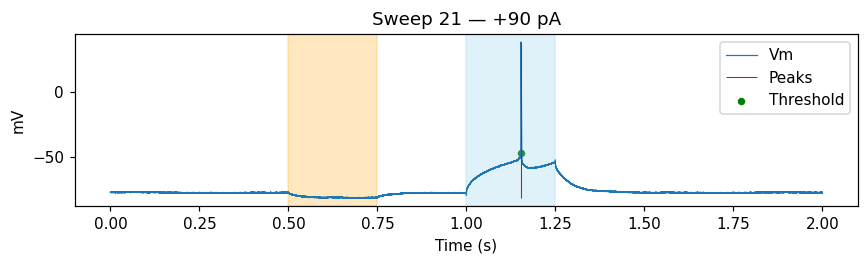

Sweep 21 has 1 spikes


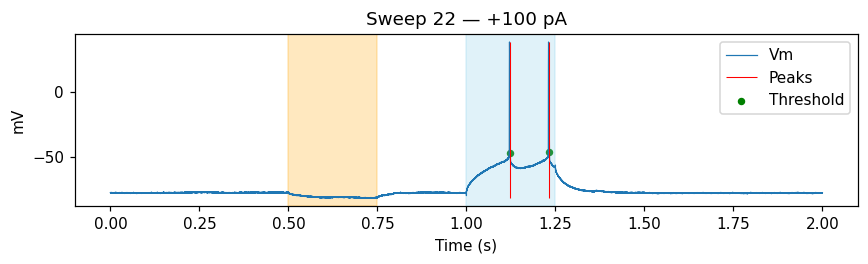

Sweep 22 has 2 spikes


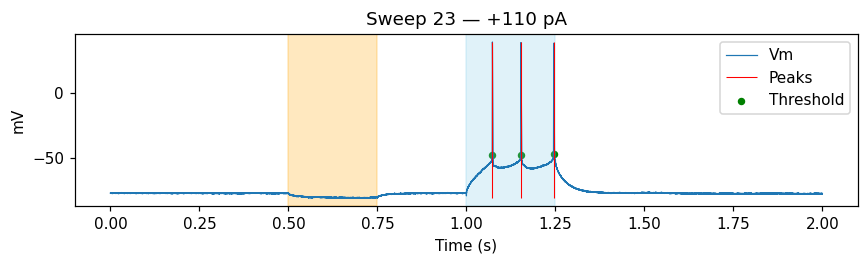

Sweep 23 has 3 spikes


In [9]:
# ---------------------------------------------------------------------
# 🔬  PER-SPIKE METRICS  (half-width, AHP, threshold, dV/dt-max)
# ---------------------------------------------------------------------
THRESH_DVDT = 50        # mV/ms
PRE_WIN_MS  = 3.0       # window to search threshold before peak

spk_rows = []

for sw_idx, (sw, (ts, te, es, ee), peaks) in enumerate(
        zip(sweeps, pulse_bounds, peaks_per_sweep), 1):

    if es is None or not len(peaks):
        continue

    dt       = 1 / sw.sample_rate
    dvdt     = np.gradient(sw.response_mV, dt*1e3)          # mV/ms
    I_inj_pA = np.mean(sw.command_pA[es:ee])                # pA

    win_pts  = int(PRE_WIN_MS/1000 / dt)

    for p_num, pk in enumerate(peaks):
        # ----- threshold: first idx where dv/dt crosses +THRESH_DVDT -----
        dv_seg = dvdt[pk-win_pts: pk]
        gt = np.where(dv_seg > THRESH_DVDT)[0]
        thresh_idx = pk-win_pts+gt[0] if gt.size else pk  # fallback = pk
        thresh_mV  = sw.response_mV[thresh_idx]

        # ----- half-width ------------------------------------------------
        prom  = signal.peak_prominences(sw.response_mV, [pk])[0][0]
        hw_ms = half_width(sw.response_mV, pk, sw.sample_rate, prom)

        # ----- AHP (to +6 ms after peak) ---------------------------------
        ahp_mV = abs(sw.response_mV[pk: pk+int(0.006/dt)].min() - thresh_mV)

        # ----- dv/dt max ±3 ms ------------------------------------------
        dv_max = dvdt[pk-win_pts: pk+win_pts].max()

        spk_rows.append(dict(
            sweep              = sw_idx,
            spike_number       = p_num,
            current_inj_pA     = I_inj_pA,
            peak_mV            = sw.response_mV[pk],
            half_width_ms      = hw_ms,
            AHP_mV             = ahp_mV,
            threshold_mV       = thresh_mV,
            dvdt_max_mV_per_ms = dv_max
        ))

spk_df = pd.DataFrame(spk_rows)
display(spk_df.head())

# ─── Diagnostic plot for every sweep that contains spikes ──────────────
if SHOW_SPIKE_PLOTS:
    for sw_idx, (sw, (ts, te, es, ee), peaks) in enumerate(
            zip(sweeps, pulse_bounds, peaks_per_sweep), 1):

        if es is None or not len(peaks):
            continue

        thresh_vals = spk_df.loc[
            (spk_df["sweep"] == sw_idx), "threshold_mV"].values

        plt.figure(figsize=(8,2.5))
        plt.plot(sw.time, sw.response_mV, lw=.8, label="Vm")
        plt.vlines(sw.time[peaks], sw.response_mV.min(),
                   sw.response_mV.max(), color='red', lw=.7, label="Peaks")
        plt.scatter(sw.time[peaks], thresh_vals, c='green',
                    s=15, label="Threshold")
        plt.axvspan(sw.time[ts], sw.time[te], color='orange', alpha=.25)
        plt.axvspan(sw.time[es], sw.time[ee], color='skyblue', alpha=.25)
        plt.ylabel("mV"); plt.xlabel("Time (s)")
        inj = np.round(np.mean(sw.command_pA[es:ee]))
        plt.title(f"Sweep {sw_idx} — {inj:+.0f} pA")
        plt.legend(loc="upper right"); plt.tight_layout(); plt.show()
        print(f"Sweep {sw_idx} has {len(peaks)} spikes")





## Summary tables

* **VC passive mean**  
  *Ra, Rm, Cm* (see print-out in cell ⑤)

* **CC passive per-sweep:** see `cc_df` above  
* **F–I table:** see `fi_df` above  
* **Spike metrics:** see `spk_df` above  

---

### TODO

* (Normalised F–I curve was removed – decide on a robust Cm source first.)  
* Consider moving helper functions into a dedicated `analysis_utils.py` for reuse.
